In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# Install required libraries
!pip install torch
!pip install transformers
!pip install sentence-transformers

import os
import torch
from transformers import AutoTokenizer, VisualBertForPreTraining
from sentence_transformers import SentenceTransformer, util
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.3/163.3 kB 4.2 MB/s eta 0:00:00a 0:00:01


In [5]:
# Load pretrained VisualBERT model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-uncased")
model = VisualBertForPreTraining.from_pretrained("uclanlp/visualbert-vqa-coco-pre")

# Load Flickr8k dataset
image_dir = "/kaggle/input/flickr8k/Images"
caption_file = "/kaggle/input/flickr8k/captions.txt"

In [8]:
# Preprocess captions
captions = {}
with open(caption_file, "r") as f:
    for line in f:
        parts = line.strip().split(",")
        image_id, caption = parts[0], parts[1]
        if image_id not in captions:
            captions[image_id] = []
        captions[image_id].append(caption)

In [9]:
# Preprocess images
image_paths = [os.path.join(image_dir, img) for img in os.listdir(image_dir)]

# Define a function to preprocess text queries
def preprocess_text(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)
    return inputs


In [10]:
def retrieve_images(text_query):
    # Tokenize input text
    inputs = tokenizer(text_query, return_tensors="pt", padding=True, truncation=True)

    # Forward pass through the model
    outputs = model(**inputs)

    # Get the text features (prediction_logits)
    # Access text features based on the output structure
    if isinstance(outputs, tuple):
        # If return_dict=False or config.return_dict=False
        text_features = outputs[0]
    else:
        # If return_dict=True and config.return_dict=True
        text_features = outputs.prediction_logits

    # You can use the text_features for further processing or analysis
    return text_features

# Example usage
text_query = "a dog running on the beach"
text_features = retrieve_images(text_query)

# Display the text features
print(text_features.shape)
print(text_features[0])



torch.Size([1, 8, 30522])
tensor([[ -5.7785,  -5.8688,  -5.9134,  ...,  -5.4533,  -5.2127,  -3.7220],
        [-14.5406, -14.3933, -14.9188,  ..., -13.2334, -15.6810, -10.2848],
        [-10.3301, -10.3732, -10.6983,  ...,  -8.9821, -10.5775,  -8.9242],
        ...,
        [-17.9176, -17.4858, -16.9816,  ..., -15.6774, -14.6666, -14.1419],
        [ -8.2552,  -7.0935,  -7.7878,  ...,  -8.3184,  -9.6705,  -6.5133],
        [-10.4109,  -9.2196, -10.1452,  ...,  -8.3673,  -8.1191,  -9.7630]],
       grad_fn=<SelectBackward0>)


In [12]:
import os
import random
from PIL import Image
import matplotlib.pyplot as plt

# Function to retrieve images related to text query based on captions in the Flickr8k dataset
def retrieve_images(text_query, captions_dir, images_dir):
    # Read captions file to find images related to the text query
    relevant_image_files = []
    with open(captions_dir, "r") as f:
        for line in f:
            image_file, caption = line.strip().split("\t")
            # Extract only the image filename without any additional characters
            image_file = image_file.split("#")[0]
            if text_query.lower() in caption.lower():
                relevant_image_files.append(image_file)

    # If no relevant images found, display a random image
    if not relevant_image_files:
        print("No relevant images found. Displaying a random image.")
        image_files = os.listdir(images_dir)
        relevant_image_file = random.choice(image_files)
    else:
        relevant_image_file = random.choice(relevant_image_files)

    # Open and display the relevant image
    image_path = os.path.join(images_dir, relevant_image_file)
    image = Image.open(image_path)

    # Display the image
    plt.imshow(image)
    plt.axis('off')
    plt.show()

# Example usage
text_query = "football on a field "
captions_dir = "/kaggle/input/flickr8k/captions.txt"
images_dir = "/kaggle/input/flickr8k/Images"
retrieve_images(text_query, captions_dir, images_dir)


ValueError: not enough values to unpack (expected 2, got 1)

In [14]:
import os
import random
from PIL import Image
import matplotlib.pyplot as plt

# Function to retrieve images related to text query based on captions in the Flickr8k dataset
def retrieve_images(text_query, captions_dir, images_dir):
    # Read captions file to find images related to the text query
    relevant_image_files = []
    for line in open(captions_dir, "r"):
        image_file, caption = line.strip().split(",")
        # Extract only the image filename without any additional characters
        image_file = image_file.split("#")[0]
        if text_query.lower() in caption.lower():
            relevant_image_files.append(image_file)

    # If no relevant images found, display an image related to at least one part of the query
    if not relevant_image_files:
        print("No relevant images found. Displaying an image related to at least one part of the query.")
        relevant_image_files = []
        for word in text_query.split():
            for line in open(captions_dir, "r"):
                image_file, caption = line.strip().split(",")
                image_file = image_file.split("#")[0]
                if word.lower() in caption.lower() and image_file not in relevant_image_files:
                    relevant_image_files.append(image_file)
                    break

    # If still no relevant images found, display a random image
    if not relevant_image_files:
        print("No images found related to any part of the query. Displaying a random image.")
        image_files = os.listdir(images_dir)
        relevant_image_file = random.choice(image_files)
    else:
        relevant_image_file = random.choice(relevant_image_files)

    # Open and display the relevant image
    image_path = os.path.join(images_dir, relevant_image_file)
    image = Image.open(image_path)

    # Display the image
    plt.imshow(image)
    plt.axis('off')
    plt.show()

# Example usage
text_query = "boy running on the road  "
captions_dir = "/kaggle/input/flickr8k/captions.txt"
images_dir = "/kaggle/input/flickr8k/Images"
retrieve_images(text_query, captions_dir, images_dir)


ValueError: too many values to unpack (expected 2)

In [18]:
import os
from PIL import Image
import matplotlib.pyplot as plt

def retrieve_images(text_query, captions_dir, images_dir):
    relevant_image_files = []

    # Read captions file to find images related to the text query
    for line in open(captions_dir, "r"):
        values = line.strip().split(",", maxsplit=1)
        if len(values) != 2:
            print(f"Warning: line '{line.strip()}' contains {len(values)} values, expected 2.")
            continue
        image_file, caption = values
        image_file = image_file.split("#")[0]
        if text_query.lower() in caption.lower():
            relevant_image_files.append(image_file)


    # If still no relevant images found, display an error message
    if not relevant_image_files:
        print("No relevant images found.")
        return

    # Choose the first relevant image found
    relevant_image_file = relevant_image_files[0]

    # Open and display the relevant image
    image_path = os.path.join(images_dir, relevant_image_file)
    image = Image.open(image_path)

    # Display the image
    plt.imshow(image)
    plt.axis('off')
    plt.show()

# Example usage
text_query = "a lady in the garden"
captions_dir = "/kaggle/input/flickr8k/captions.txt"
images_dir = "/kaggle/input/flickr8k/Images"
retrieve_images(text_query, captions_dir, images_dir)


No relevant images found.


In [24]:
import os
from PIL import Image
import matplotlib.pyplot as plt

def retrieve_images(text_query, captions_dir, images_dir):
    relevant_image_files = []

    # Find the longest substring of the query that matches any caption
    longest_substring = ""
    for line in open(captions_dir, "r"):
        values = line.strip().split(",", maxsplit=1)
        if len(values) != 2:
            print(f"Warning: line '{line.strip()}' contains {len(values)} values, expected 2.")
            continue
        image_file, caption = values
        image_file = image_file.split("#")[0]
        for substring in find_substrings(text_query, caption):
            if len(substring) > len(longest_substring):
                longest_substring = substring

    # If a substring was found, search for images related to that substring
    if longest_substring:
        for line in open(captions_dir, "r"):
            values = line.strip().split(",", maxsplit=1)
            if len(values) != 2:
                print(f"Warning: line '{line.strip()}' contains {len(values)} values, expected 2.")
                continue
            image_file, caption = values
            image_file = image_file.split("#")[0]
            if longest_substring.lower() in caption.lower():
                relevant_image_files.append(image_file)

    # If no relevant images were found, display an error message
    if not relevant_image_files:
        print("No relevant images found.")

def find_substrings(query, caption):
    """
    Find all substrings of the query that match any substring of the caption.
    """
    substrings = set()
    for i in range(len(query)):
        for j in range(i, len(query)):
            substring = query[i:j+1]
            if substring in caption:
                substrings.add(substring)
    return substrings

    # Choose the first relevant image found
    relevant_image_file = relevant_image_files[0]

    # Open and display the relevant image
    image_path = os.path.join(images_dir, relevant_image_file)
    image = Image.open(image_path)

    # Display the image
    plt.imshow(image)
    plt.axis('off')
    plt.show()

# Example usage
text_query = "a man with beard"
captions_dir = "/kaggle/input/flickr8k/captions.txt"
images_dir = "/kaggle/input/flickr8k/Images"
retrieve_images(text_query, captions_dir, images_dir)


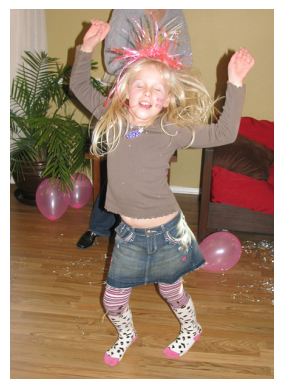

In [12]:
import os
import re
from PIL import Image
import matplotlib.pyplot as plt


def retrieve_images(text_query, captions_dir, images_dir):
    """
    Find relevant images for a text query, and display the first relevant image found.
    """
    relevant_image_files = []

    # Read captions file to find images related to the text query
    with open(captions_dir, "r") as f:
        for line in f:
            values = line.strip().split(",", maxsplit=1)
            if len(values) != 2:
                print(f"Warning: line '{line.strip()}' contains {len(values)} values, expected 2.")
                continue
            image_file, caption = values
            image_file = image_file.split("#")[0]
            if text_query.lower() in caption.lower():
                relevant_image_files.append(image_file)

    # If no relevant images were found, search for images related to the longest substring of the query
    if not relevant_image_files:
        longest_substring = find_longest_substring(text_query, captions_dir)
        if longest_substring:
            print(f"The longest substring of the query is '{longest_substring}'.")
            for line in open(captions_dir, "r"):
                values = line.strip().split(",", maxsplit=1)
                if len(values) != 2:
                    print(f"Warning: line '{line.strip()}' contains {len(values)} values, expected 2.")
                    continue
                image_file, caption = values
                image_file = image_file.split("#")[0]
                if longest_substring.lower() in caption.lower():
                    relevant_image_files.append(image_file)
                    break

    # Choose the first relevant image file
    relevant_image_file = relevant_image_files[0]

    # Open and display the relevant image
    image_path = os.path.join(images_dir, relevant_image_file)
    image = Image.open(image_path)
    plt.imshow(image)
    plt.axis('off')
    plt.show()

def find_longest_substring(query, captions_dir):
    """
    Find the longest substring of the query that matches any caption.
    """
    longest_substring = ""
    for line in open(captions_dir, "r"):
        values = line.strip().split(",", maxsplit=1)
        if len(values) != 2:
            print(f"Warning: line '{line.strip()}' contains {len(values)} values, expected 2.")
            continue
        image_file, caption = values
        image_file = image_file.split("#")[0]
        for substring in find_substrings(query, caption):
            if len(substring) > len(longest_substring):
                longest_substring = substring
    return longest_substring

def find_substrings(query, caption):
    """
    Find all substrings of the query that match any substring of the caption.
    """
    substrings = set()
    for i in range(len(query)):
        for j in range(i, len(query)):
            substring = query[i:j+1]
            if substring in caption:
                substrings.add(substring)
    return substrings
# Example usage
text_query = "girl dancing"
captions_dir = "/kaggle/input/flickr8k/captions.txt"
images_dir = "/kaggle/input/flickr8k/Images"
retrieve_images(text_query, captions_dir, images_dir)

The longest substring of the query is 'one barking'.


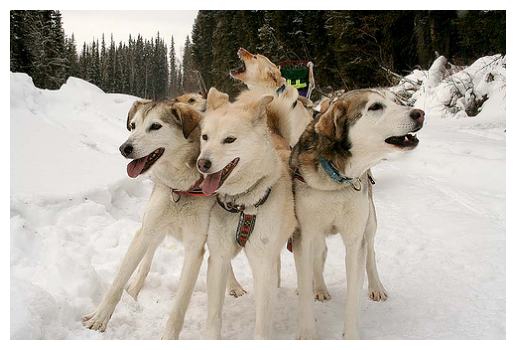

In [10]:
import os
import re
from PIL import Image
import matplotlib.pyplot as plt


def retrieve_images(text_query, captions_dir, images_dir, num_images=5):
    """
    Find relevant images for a text query, and display the top relevant images found.
    """
    relevant_image_files = []

    # Read captions file to find images related to the text query
    with open(captions_dir, "r") as f:
        for line in f:
            values = line.strip().split(",", maxsplit=1)
            if len(values) != 2:
                print(f"Warning: line '{line.strip()}' contains {len(values)} values, expected 2.")
                continue
            image_file, caption = values
            image_file = image_file.split("#")[0]
            if text_query.lower() in caption.lower():
                relevant_image_files.append(image_file)

    # If no relevant images were found, search for images related to the longest substring of the query
    if not relevant_image_files:
        longest_substring = find_longest_substring(text_query, captions_dir)
        if longest_substring:
            print(f"The longest substring of the query is '{longest_substring}'.")
            for line in open(captions_dir, "r"):
                values = line.strip().split(",", maxsplit=1)
                if len(values) != 2:
                    print(f"Warning: line '{line.strip()}' contains {len(values)} values, expected 2.")
                    continue
                image_file, caption = values
                image_file = image_file.split("#")[0]
                if longest_substring.lower() in caption.lower():
                    relevant_image_files.append(image_file)
                    break

    # Choose the top relevant image files
    relevant_image_files = relevant_image_files[:num_images]

    # Open and display the relevant images
    for image_file in relevant_image_files:
        image_path = os.path.join(images_dir, image_file)
        image = Image.open(image_path)
        plt.imshow(image)
        plt.axis('off')
        plt.show()

# Example usage
text_query = "everyone barking"
captions_dir = "/kaggle/input/flickr8k/captions.txt"
images_dir = "/kaggle/input/flickr8k/Images"
retrieve_images(text_query, captions_dir, images_dir, num_images=5)

The longest substring of the query is 'one barking'.


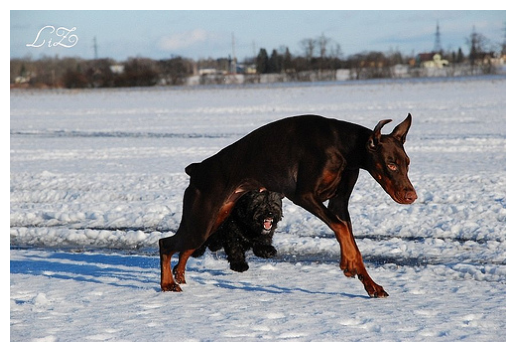

In [19]:
def retrieve_images(text_query, captions_dir, images_dir, num_images=5):
    """
    Find relevant images for a text query, and display the top relevant images found.
    """
    relevant_image_files = []

    # Read captions file to find images related to the text query
    with open(captions_dir, "r") as f:
        for line in f:
            values = line.strip().split(",", maxsplit=1)
            if len(values) != 2:
                print(f"Warning: line '{line.strip()}' contains {len(values)} values, expected 2.")
                continue
            image_file, caption = values
            image_file = image_file.split("#")[0]
            if text_query.lower() in caption.lower():
                relevant_image_files.append(image_file)

    # If no relevant images were found, search for images related to the longest substring of the query
    if not relevant_image_files:
        longest_substring = find_longest_substring(text_query, captions_dir)
        if longest_substring:
            print(f"The longest substring of the query is '{longest_substring}'.")
            found_images = 0
            for line in open(captions_dir, "r"):
                values = line.strip().split(",", maxsplit=1)
                if len(values) != 2:
                    print(f"Warning: line '{line.strip()}' contains {len(values)} values, expected 2.")
                    continue
                image_file, caption = values
                image_file = image_file.split("#")[0]
                if longest_substring.lower() in caption.lower():
                    relevant_image_files.append(image_file)
                    found_images += 1
                    if found_images >= num_images:
                        break

    # Choose the top relevant image files
    relevant_image_files = relevant_image_files[:num_images]
    
    # Open and display the relevant images
    for image_file in relevant_image_files:
        image_path = os.path.join(images_dir, image_file)
        image = Image.open(image_path)
        plt.imshow(image)
        plt.axis('off')
    plt.show()
    
    # Example usage
text_query = "everyone barking"
captions_dir = "/kaggle/input/flickr8k/captions.txt"
images_dir = "/kaggle/input/flickr8k/Images"
retrieve_images(text_query, captions_dir, images_dir, num_images=5)


Only 2 relevant images found. Displaying all of them.


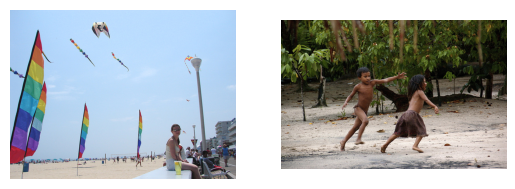

In [13]:

import os
import random
from PIL import Image
import matplotlib.pyplot as plt

# Function to retrieve images related to text query based on captions in the Flickr8k dataset
def retrieve_top_images(text_query, captions_dir, images_dir, num_images=5):
    relevant_image_files = []
    with open(captions_dir, "r") as f:
        for line in f:
            values = line.strip().split(",", maxsplit=1)
            if len(values) != 2:
                print(f"Warning: line '{line.strip()}' contains {len(values)} values, expected 2.")
                continue
            image_file, caption = values
            image_file = image_file.split("#")[0]
            if text_query.lower() in caption.lower():
                relevant_image_files.append(image_file)

    if not relevant_image_files:
        print("No relevant images found. Displaying images related to at least one part of the query.")
        for word in text_query.split():
            for line in open(captions_dir, "r"):
                values = line.strip().split(",", maxsplit=1)
                if len(values) != 2:
                    print(f"Warning: line '{line.strip()}' contains {len(values)} values, expected 2.")
                    continue
                image_file, caption = values
                image_file = image_file.split("#")[0]
                if word.lower() in caption.lower() and image_file not in relevant_image_files:
                    relevant_image_files.append(image_file)
                    if len(relevant_image_files) >= num_images:
                        break

    if not relevant_image_files:
        print("No images found related to any part of the query. Displaying random images.")
        image_files = os.listdir(images_dir)
        relevant_image_files = random.sample(image_files, num_images)

    if len(relevant_image_files) < num_images:
        print(f"Only {len(relevant_image_files)} relevant images found. Displaying all of them.")
        num_images = len(relevant_image_files)

    # Open and display the relevant images
    for i in range(num_images):
        image_path = os.path.join(images_dir, relevant_image_files[i])
        image = Image.open(image_path)

        # Display the image
        plt.subplot(1, num_images, i+1)
        plt.imshow(image)
        plt.axis('off')

    plt.show()

# Example usage
text_query = "girl on a beach"
captions_dir = "/kaggle/input/flickr8k/captions.txt"
images_dir = "/kaggle/input/flickr8k/Images"
retrieve_top_images(text_query, captions_dir, images_dir, num_images=5)
